# Global constants

In [360]:
#GRAIN_TYPE = 'generated_wheat'
GRAIN_TYPE = 'WheatAdded_Type'


FILENAME_BEST_MODEL = 'Best models/target_2/hybrid_models/' + GRAIN_TYPE + '_t2_kcv_dnn_mc.h5'

In [361]:
#Import libraries
import requests
import pandas as pd


#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt
import random
#Data Manipulation
import pandas as pd
import numpy as np

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, KFold
np.random.seed(39)
random.seed(39)
tf.random.set_seed(39)
print(tf.__version__)

2.4.1


In [362]:
print(tf.config.list_physical_devices('GPU'))
# print(tf.version.VERSION)

[]


## Helper functions

In [363]:
def calculate_r_squared(y_true, y_pred):
   corr_matrix = np.corrcoef(y_true, y_pred)
   corr = corr_matrix[0,1]
   R_sq = corr**2
   return R_sq
def print_variety_counts(df, train_idx, test_idx, variety_column='Variety'):
    # Extracting varieties based on indices
    train_varieties = df.loc[train_idx, variety_column]
    test_varieties = df.loc[test_idx, variety_column]
    
    # Counting occurrences
    train_counts = train_varieties.value_counts()
    test_counts = test_varieties.value_counts()
    
    # Printing
    print("Training Set Variety Counts:")
    print(train_counts, "\n")
    print("Testing Set Variety Counts:")
    print(test_counts)

def calculate_errors_by_variety(df, Y_pred, Y_actual, test_idx, variety_column='Variety'):
    # Create DataFrame from test_idx to map back to original df
    test_varieties = df.loc[test_idx, variety_column].reset_index(drop=True)
    
    # Convert predictions and actual values to DataFrame
    predictions_df = pd.DataFrame({'Predicted': Y_pred.flatten(), 'Actual': Y_actual.flatten()})
    
    # Add variety information
    predictions_df['Variety'] = test_varieties
    
    # Calculate absolute error
    predictions_df['AbsError'] = abs(predictions_df['Predicted'] - predictions_df['Actual'])
    
    # Group by variety and calculate max and mean error
    error_stats = predictions_df.groupby('Variety')['AbsError'].agg(['max', 'mean']).reset_index()
    
    # Rename columns for better readability
    error_stats.rename(columns={'max': 'MaxError', 'mean': 'AvgError'}, inplace=True)
    
    # Print results
    print(error_stats)

# Example usage:

def plot_loss_curve(history, epoch_size):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(0,epoch_size)
    
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend()
    plt.show()

def plot_line(metric, title, xlabel):
    plt.figure(figsize=(8,3))
    plt.title(title, fontsize = 16)
    plt.plot(metric)
    plt.xlabel(xlabel, fontsize = 14)
    plt.grid()
    plt.legend(loc= "best")
    plt.show()

def scatter_plot(trueValues, predictions, title):
  plt.figure(figsize=(8,3))
  ax = plt.axes()
  maxVal = max( max(trueValues), max(predictions) )

  ax.scatter(x=predictions, y=trueValues)
  ax.plot([0, 1, maxVal], [0, 1, maxVal], label="Ideal fit")
  print('Maxval here is: ', maxVal)
  plt.title(title, fontsize = 16)
  plt.xlabel("Predictions", fontsize = 14)
  plt.ylabel("Real", fontsize = 14)
  plt.grid()

In [364]:
#url dataset
URL = "../Datasets/processed/" + GRAIN_TYPE + ".csv"

#read in excel format
df = pd.read_csv(URL)
#df = df[df['Variety'] == 'SOUTH DAKOTA']
#df = df[(df['Density'] >= 0.72) & (df['Density'] <= 0.88)]

print("From USDA: ", URL)


df.head()

From USDA:  ../Datasets/processed/WheatAdded_Type.csv


,Unnamed: 0,Variety,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary,Type,Phase/Attn,Freq*d(cm),Freq*Attn
0,0,KANSAS,7.0,8.9,11.3,0.7356,8.8258,-55.973,-415.973,2.416,0.243,15.855506,-6.341975,62.3,61.7806
1,1,KANSAS,8.0,8.9,11.3,0.7356,10.2572,-114.289,-474.289,2.412,0.246,15.855506,-11.142320,71.2,82.0576
2,2,KANSAS,9.0,8.9,11.3,0.7356,11.5679,-168.171,-528.171,2.395,0.246,15.855506,-14.537729,80.1,104.1111
3,3,KANSAS,10.0,8.9,11.3,0.7356,12.8795,134.849,-585.151,2.390,0.246,15.855506,10.470049,89.0,128.7950
4,4,KANSAS,11.0,8.9,11.3,0.7356,13.7649,83.502,-636.498,2.371,0.238,15.855506,6.066299,97.9,151.4139


In [365]:
# Dimension of the dataset
df.shape

(806, 15)

In [366]:
# Check info about missing values in dataframe
df.isnull().sum()

Unnamed: 0                0
Variety                   0
Freq                      0
d(cm)                     0
M%                        0
Density                   0
Attn                      0
Phase                     0
Phase_Corr                0
Permittivity_real         0
Permittivity_imaginary    0
Type                      0
Phase/Attn                0
Freq*d(cm)                0
Freq*Attn                 0
dtype: int64

# Exploratory Data Analysis


# Data preparation


1.   Convert dataframe to numpy array for flexibility.
2. Split our data into training and testing datasets and store the target values in different variables.
3.   Normalize the features by applying some operations in the data sets.




In [367]:
# Convert to numpy array
df_features = df[['Freq', 
                    'd(cm)', 
                    'Phase_Corr', 
                    'Permittivity_real', 
                    'Permittivity_imaginary',
                    'Type',
                    ]]

df_targets = df[['M%']]
# df_targets = df[['Density', 'M%']]

dataset_x = df_features.to_numpy()
dataset_y = df_targets.to_numpy()

## Splitting dataset to test and train+validate

In [368]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
#Normalizing the data set
dataset_x_norm  = normalize(dataset_x)
dataset_y_norm  = normalize(dataset_y)
#Define Scalers
scaler_input = MinMaxScaler()
scaler_output = MinMaxScaler()

# Scale the entire normalizeddataset (input features)
dataset_x_scaled_norm = scaler_input.fit_transform(dataset_x_norm)

# Scale the entire normalizeddataset (output targets)
dataset_y_scaled_norm  = scaler_output.fit_transform(dataset_y_norm)

# from sklearn.preprocessing import MinMaxScaler

# #Normalizing the data set
# scaler_input = MinMaxScaler()
# scaler_output = MinMaxScaler()

# # Normalize the entire dataset (input features)
# dataset_x_norm = scaler_input.fit_transform(dataset_x)  # Use transform, NOT fit_transform

# # Normalize the entire dataset (output targets)
# dataset_y_norm = scaler_output.fit_transform(dataset_y)  # Use transform, NOT fit_transform


## Normalize datasets

In [369]:

train_idx, test_idx = train_test_split(df.index, test_size=0.20, random_state=39)
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(dataset_x_scaled_norm, dataset_y_scaled_norm, 
                                                    test_size=0.20
                                                    ,random_state=39
                                                    )


# K-cross Validation
* Input features: 7
* Output targets: 2


## Defining model

In [370]:
from keras import layers, Sequential, regularizers

# Define the model-building function
def my_model():
  my_model = Sequential([
    
    layers.Dense(128, input_shape=(6,), activation='relu',),
    layers.Dense(128, activation='relu', ),
    layers.Dense(128, activation='relu',),
    layers.Dense(1, activation='linear')  # Output layer with 2 neurons for the two regression targets
  ])

  opt = tf.keras.optimizers.Adam(learning_rate=0.00091) # 0.0006 
  my_model.compile(
      optimizer = opt,
      loss = 'mse',
      metrics = ['accuracy']
  )

  return my_model

plot_model(my_model(), show_shapes=True, show_layer_names=True)
my_model().summary()

Model: "sequential_181"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1150 (Dense)           (None, 128)               896       
_________________________________________________________________
dense_1151 (Dense)           (None, 128)               16512     
_________________________________________________________________
dense_1152 (Dense)           (None, 128)               16512     
_________________________________________________________________
dense_1153 (Dense)           (None, 1)                 129       
Total params: 34,049
Trainable params: 34,049
Non-trainable params: 0
_________________________________________________________________


## Running model with KCV

In [371]:
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.callbacks import Callback
class MaxAbsErrorCallback(Callback):
    def __init__(self):  
        self.max_abs_errors = np.zeros((K_FOLD_SPLITS, NUM_EPOCHS))  # Initialize array

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(X_test) 
        y_pred = scaler_output.inverse_transform(y_pred) 
        y_true = scaler_output.inverse_transform(y_test) 

        abs_errors = np.abs(y_true[:, 0] - y_pred[:, 0])
        max_abs_error = np.max(abs_errors)

        # Store errors in the pre-allocated Array
        fold_index = cv.get_n_splits() - 1  # Get the current fold index
        self.max_abs_errors[fold_index, epoch] = max_abs_error 
        # print(f"Epoch {epoch + 1}: Max Absolute Error = {max_abs_error:.4f}") 

    def on_train_end(self, logs={}):  
        epoch_averages = np.mean(self.max_abs_errors, axis=0)  # Average across folds
        # print(min(epoch_averages))
        # for epoch_idx, avg_error in enumerate(epoch_averages):
        #     print(f"Epoch {epoch_idx + 1} Average Max Abs Error: {avg_error:.4f}")

NUM_EPOCHS = 190# 180
BATCH_SIZE = 10
K_FOLD_SPLITS = 10


# Define the cross-validation process to be used inside cross_val_Score evaluation
cv = KFold(n_splits=K_FOLD_SPLITS)

# Handling for accommodating multiple targets
Y = y_train[:,0]

X = X_train

i = 0
arr_loss = list()
min_loss = 1000000
best_model = None
history = None
history_best_model = None


# Perform k-fold cross-validation
for train_indices, test_indices in cv.split(X_train):
  print('####################### Iteration  ', i, ' #######################')
  trainX, testX = np.array(X[train_indices]), np.array(X[test_indices])
  trainY = (Y[train_indices])
  testY = (Y[test_indices])

  model = my_model()
  history = model.fit(trainX, trainY,
            epochs=NUM_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data = (testX, testY),
            callbacks=[MaxAbsErrorCallback()],  # Add the callback
            verbose = 0
  )


  #testing on validation set process
  loss, rmse = model.evaluate(x = testX, y = testY, verbose=0)
  
  print(f"Loss = {loss}, rmse = {rmse}" )

  if loss < min_loss:
    best_model = model
    history_best_model = history
    min_loss = loss

  arr_loss.append(loss)
  print('Loss array: ', arr_loss)
  i+=1

# Saving the best model within the k folds
best_model.save('Best models/target_2/single_models/density_kfold_dnn_single')

####################### Iteration   0  #######################


Loss = 1.140011349209935e-11, rmse = 1.0
Loss array:  [1.140011349209935e-11]
####################### Iteration   1  #######################
Loss = 1.7823079678791487e-09, rmse = 1.0
Loss array:  [1.140011349209935e-11, 1.7823079678791487e-09]
####################### Iteration   2  #######################


# Results
- Plot of k-cross validation performance
- Scatter Plot of prediction results against true values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


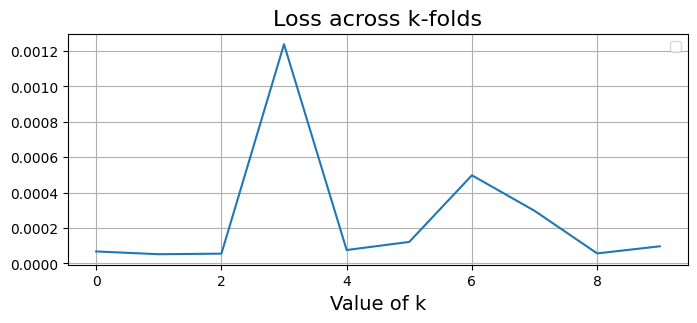

In [ ]:
# Loss across k folds
plot_line(arr_loss, "Loss across k-folds", "Value of k")

### Loss curves

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


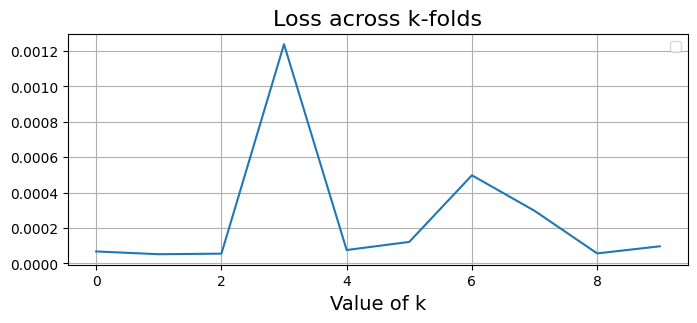

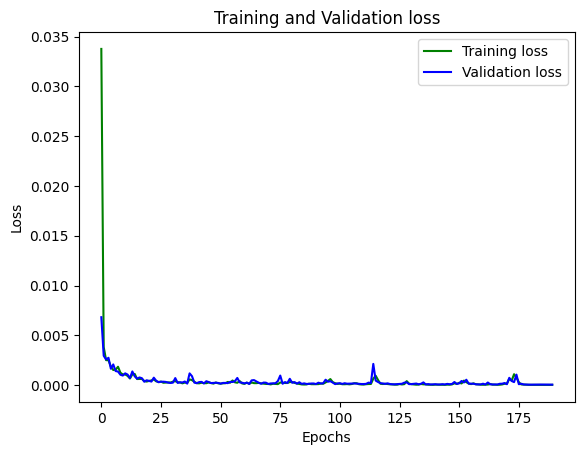

In [ ]:
def plot_loss_curve(history, epoch_size):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(0,epoch_size)
    
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend()
    plt.show()



# Loss across k folds
plot_line(arr_loss, "Loss across k-folds", "Value of k")

# Training and Validation Loss
plot_loss_curve(history_best_model, NUM_EPOCHS)

# Prediction on Test Dataset

Elapsed time: 0.0146 seconds
Maxval here is:  24.799765


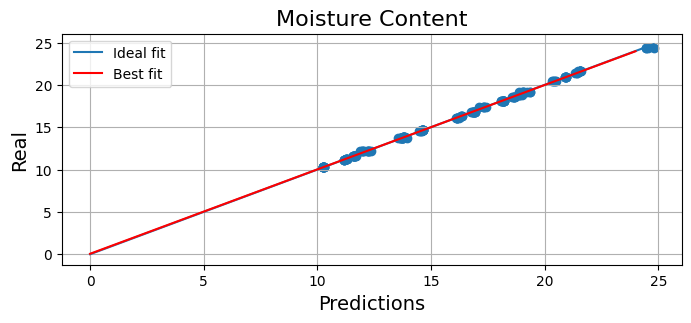

In [ ]:
import time

start_time = time.time()
Y_pred_normalized = best_model.predict(X_test)
end_time = time.time()
Y_pred_normalized_entire = best_model.predict(dataset_x_norm)
# Calculate elapsed time in seconds
elapsed_time = end_time - start_time
print("Elapsed time:", round(elapsed_time, 3), "seconds")


Y_pred = scaler_output.inverse_transform(Y_pred_normalized)
Y_pred_entire = scaler_output.inverse_transform(Y_pred_normalized_entire)
Y_actual = scaler_output.inverse_transform(y_test)
Y_actual_entire = np.array(df_targets)
# Moisture Content
scatter_plot(trueValues=Y_actual[:,0], 
             predictions=Y_pred[:,0], 
             title="Moisture Content")
a, b = np.polyfit(Y_pred[:, 0], Y_actual[:, 0], 1) # y = ax + b
x_best_fit = np.arange(0, max(max(Y_pred[:,0]), max(Y_actual[:,0])), 1)
plt.plot(x_best_fit, a*x_best_fit + b, c='red', label='Best fit')
plt.legend()
plt.savefig('../Poster/Results/obj_3_MC.svg', dpi=300,
                bbox_inches='tight',
                transparent=True)

# Error analysis
- R squared calculation
- Mean accuracy error

Now we will compare with the results from Trabelsi's paper. This is single moisture prediction 

R^2 : 0.993\
Mean Squared Error: 0.028\
Mean absolute Error: 0.135\
Min. Absolute Error: 0.004\
Max Absolute Error: 0.441

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,max_error, r2_score
from sigfig import round

mc_r2_score = r2_score(y_true=Y_actual[:, 0], y_pred=Y_pred[:, 0])
print("R^2: {:#.4g}".format(mc_r2_score))
mse_mc = mean_squared_error(Y_actual[:, 0], Y_pred[:, 0], squared=True)
print('Mean Squared Error: ', "{0:.4g}".format(mse_mc))
mae_mc = mean_absolute_error(Y_actual[:, 0], Y_pred[:, 0])
print('Mean Absolute Error: ', "{0:.4g}".format(mae_mc))

sums = []
for i in range(len(Y_actual[:,0])):
    sum = Y_actual[:,0][i] - Y_pred[:,0][i]
    #print(Y_actual[:,0][i]," - ",Y_pred[:,0][i],'=',sum)
    sums.append(abs(sum))
print("Min Absolute Error: ",min(sums))
print("Max Absolute Error: ",max(sums))

print_variety_counts(df, train_idx, test_idx, 'Variety')  # Assuming 'Type' is your variety column

calculate_errors_by_variety(df, Y_pred, Y_actual, test_idx, 'Variety')

R^2: 0.9994
Mean Squared Error:  0.007797
Mean Absolute Error:  0.0615
Min Absolute Error:  0.0003349685668947444
Max Absolute Error:  0.3897646331787108
Training Set Variety Counts:
KANSAS               149
OKLAHOMA             148
NEBRASKA OVERLAND    127
NEBRASKA SETTLER     127
SOUTH DAKOTA          93
Name: Variety, dtype: int64 

Testing Set Variety Counts:
NEBRASKA OVERLAND    39
NEBRASKA SETTLER     37
OKLAHOMA             30
KANSAS               29
SOUTH DAKOTA         27
Name: Variety, dtype: int64
             Variety  MaxError  AvgError
0             KANSAS  0.093998  0.039050
1  NEBRASKA OVERLAND  0.251188  0.055327
2   NEBRASKA SETTLER  0.304796  0.105197
3           OKLAHOMA  0.389765  0.057556
4       SOUTH DAKOTA  0.121358  0.039059


In [ ]:
mc_r2_score = r2_score(Y_actual_entire[:, 0], Y_pred_entire[:, 0])
print("R^2: {:#.4g}".format(mc_r2_score))
mse_mc = mean_squared_error(Y_actual_entire[:, 0], Y_pred_entire[:, 0], squared=True)
print('Mean Squared Error: ', "{0:.4g}".format(mse_mc))
mae_mc = mean_absolute_error(Y_actual_entire[:, 0], Y_pred_entire[:, 0])
print('Mean Absolute Error: ', "{0:.4g}".format(mae_mc))

sums = []
for i in range(len(Y_actual_entire[:,0])):
    sum = Y_actual_entire[:,0][i] - Y_pred_entire[:,0][i]
    #print(Y_actual[:,0][i]," - ",Y_pred[:,0][i],'=',sum)
    sums.append(abs(sum))
print("Min Absolute Error: ",min(sums))
print("Max Absolute Error: ",max(sums))

R^2: 0.9996
Mean Squared Error:  0.00536
Mean Absolute Error:  0.05151
Min Absolute Error:  5.889892578103684e-05
Max Absolute Error:  0.3897646331787108
